In [265]:
import scipy.io
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import pandas as pd
from sklearn.linear_model import Lasso
from numpy.linalg import norm

%matplotlib inline

data =scipy.io.loadmat("IMAGES_RAW.mat")
images = data["IMAGESr"]

In [266]:
#Check the structure

images[:,:,:].shape

(512, 512, 10)

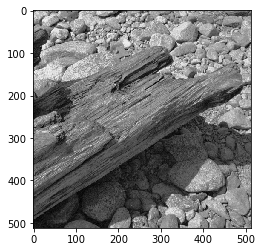

In [267]:
#Show the first image

plt.imshow(images[:,:,0], cmap="gray")

The first image in the dataset

In [268]:
# Function to sample image patches from the large images.

def sample_random_square_patches(image, num, width):
    patches =np.zeros([width,width,num]);
    for k in range(num):
        i, j = random.sample(range(image.shape[0]-width),2)
        patches[:,:,k] = image[i:i+width,j:j+width]
    return patches

In [269]:
def SparseCoding(eta, Display=1):
    width=12        #Sample image width
    k=128           #Number of sample patches
    dim=width**2    #Length of sample image feature
    L=192           #Number of feature of Dictionary based on the landmark paper
    
    Dict = np.random.random((dim, L)) #Initial Dictionary
    
    #Display initial dictionary
    if(Display==1):
        nrows = 1
        ncols = 16
        fig_np = plt.figure(figsize=(10*2,2))
        fig_np.suptitle('Image of Dictionary after initialization',fontsize=20)
        for i in range(0,nrows*ncols):
            plt.subplot(nrows, ncols, i+1)
            plt.imshow(Dict[:,i].reshape(12,12), cmap='gray')
            plt.axis('off')
        plt.show()
        
    
    mod_Lasso = Lasso(alpha=eta) #Lasso model
    
    Converge = []
    A=np.zeros((L,L));    # a*a^t (192 X 128) * (128 X 192)
    B=np.zeros((dim,L));  # x*a^t (144 * 128) * (128 X 192)
    
    flag=0   #while loop condition
    cnt=0    #Index to display several intermediate stages

    start = time.time()
    #for t in range(1024):
    while(flag==0):
        #Initial Process
        Rand_Index = np.random.randint(0,10) #Random index to pick an image 
        x_sample = sample_random_square_patches(images[:,:,Rand_Index], k, width)
        x_sample = x_sample.reshape(dim, k) #Make each patch as vector
        mod_Lasso.fit(Dict, x_sample)       #Lasso to find coefficient alpha for dictionary
        alpha = mod_Lasso.coef_.T

        A += np.dot(alpha,alpha.T)           
        B += np.dot(x_sample,alpha.T)

        #Dictionary Update
        Dict += ((B-np.dot(Dict,A)).T/np.diag(A).reshape(L,1)).T
        temp = np.sum(np.abs(Dict)**2,axis=0)**(1./2)
        temp = np.maximum(temp, 1)
        temp = temp.reshape(L,1).T
        Dict = Dict / temp
        
        cnt+=1
        if(Display==1):
            if(cnt%50==0):  #Display intermediate stage for 50 iteration
                nrows = 1
                ncols = 16
                fig_np = plt.figure(figsize=(10*2,2))
                fig_np.suptitle('Image of Dictionary at %d iteration'%(cnt),fontsize=20)
                for i in range(0,nrows*ncols):
                    plt.subplot(nrows, ncols, i+1)
                    plt.imshow(Dict[:,i].reshape(12,12), cmap='gray')
                    plt.axis('off')
                plt.show()
                

        #Convergence -> Frobenius Norm : matrix difference
        size = norm((((B-np.dot(Dict,A)).T/np.diag(A).reshape(L,1)).T), 'fro')
        if(len(Converge)<2):
            Converge.append(size)
        elif(np.abs(Converge[-1]-size)<0.001):
            Converge.append(size)
            flag=1
        else:
            Converge.append(size)
        
    TotalTime = time.time() - start
    
    return (Dict, Converge, TotalTime)  

To implement the above algorithm, I refer to the following paper.

Mairal, J., Bach, F., Ponce, J., & Sapiro, G. (2009). Online dictionary learning for sparse coding. Proceedings of the 26th Annual International Conference on Machine Learning - ICML 09

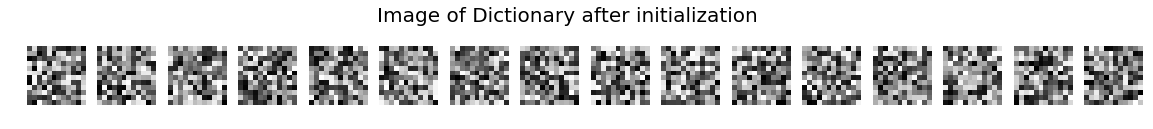

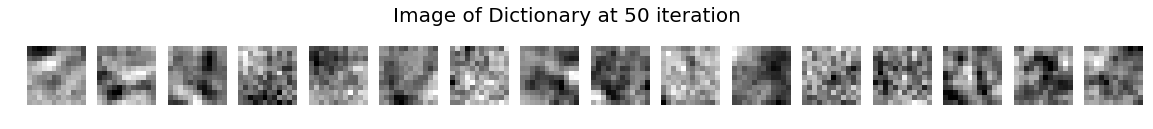

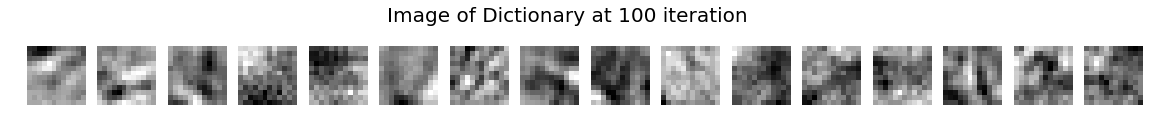

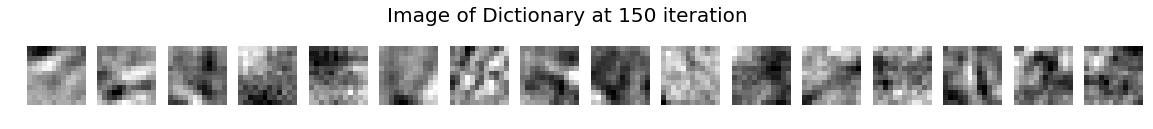

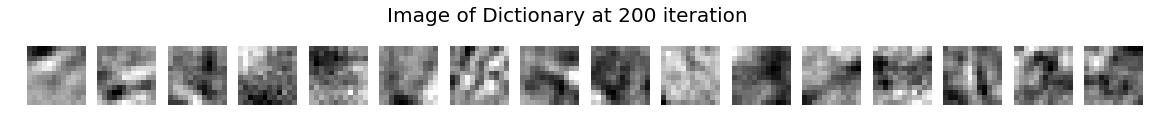

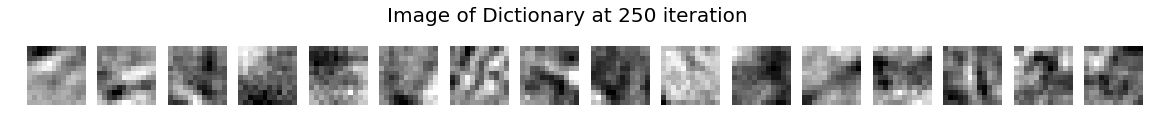

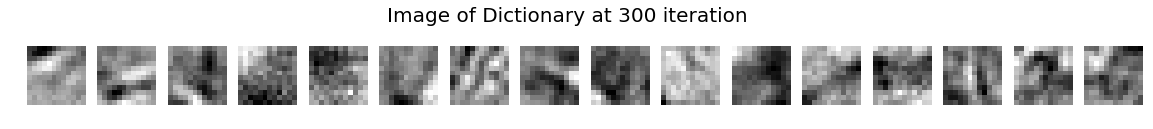

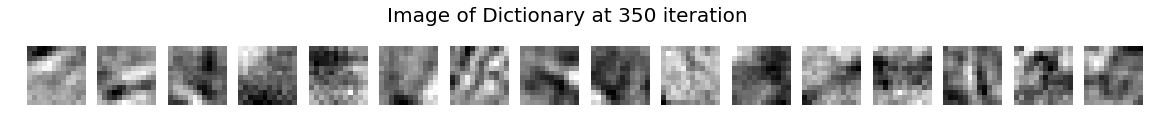

In [271]:
Dict,Converge,Time = SparseCoding(eta=0.005)

For intermediate stages, I only display first 10 atoms in the dictionary at given iteration.

## Codebook after convergence 

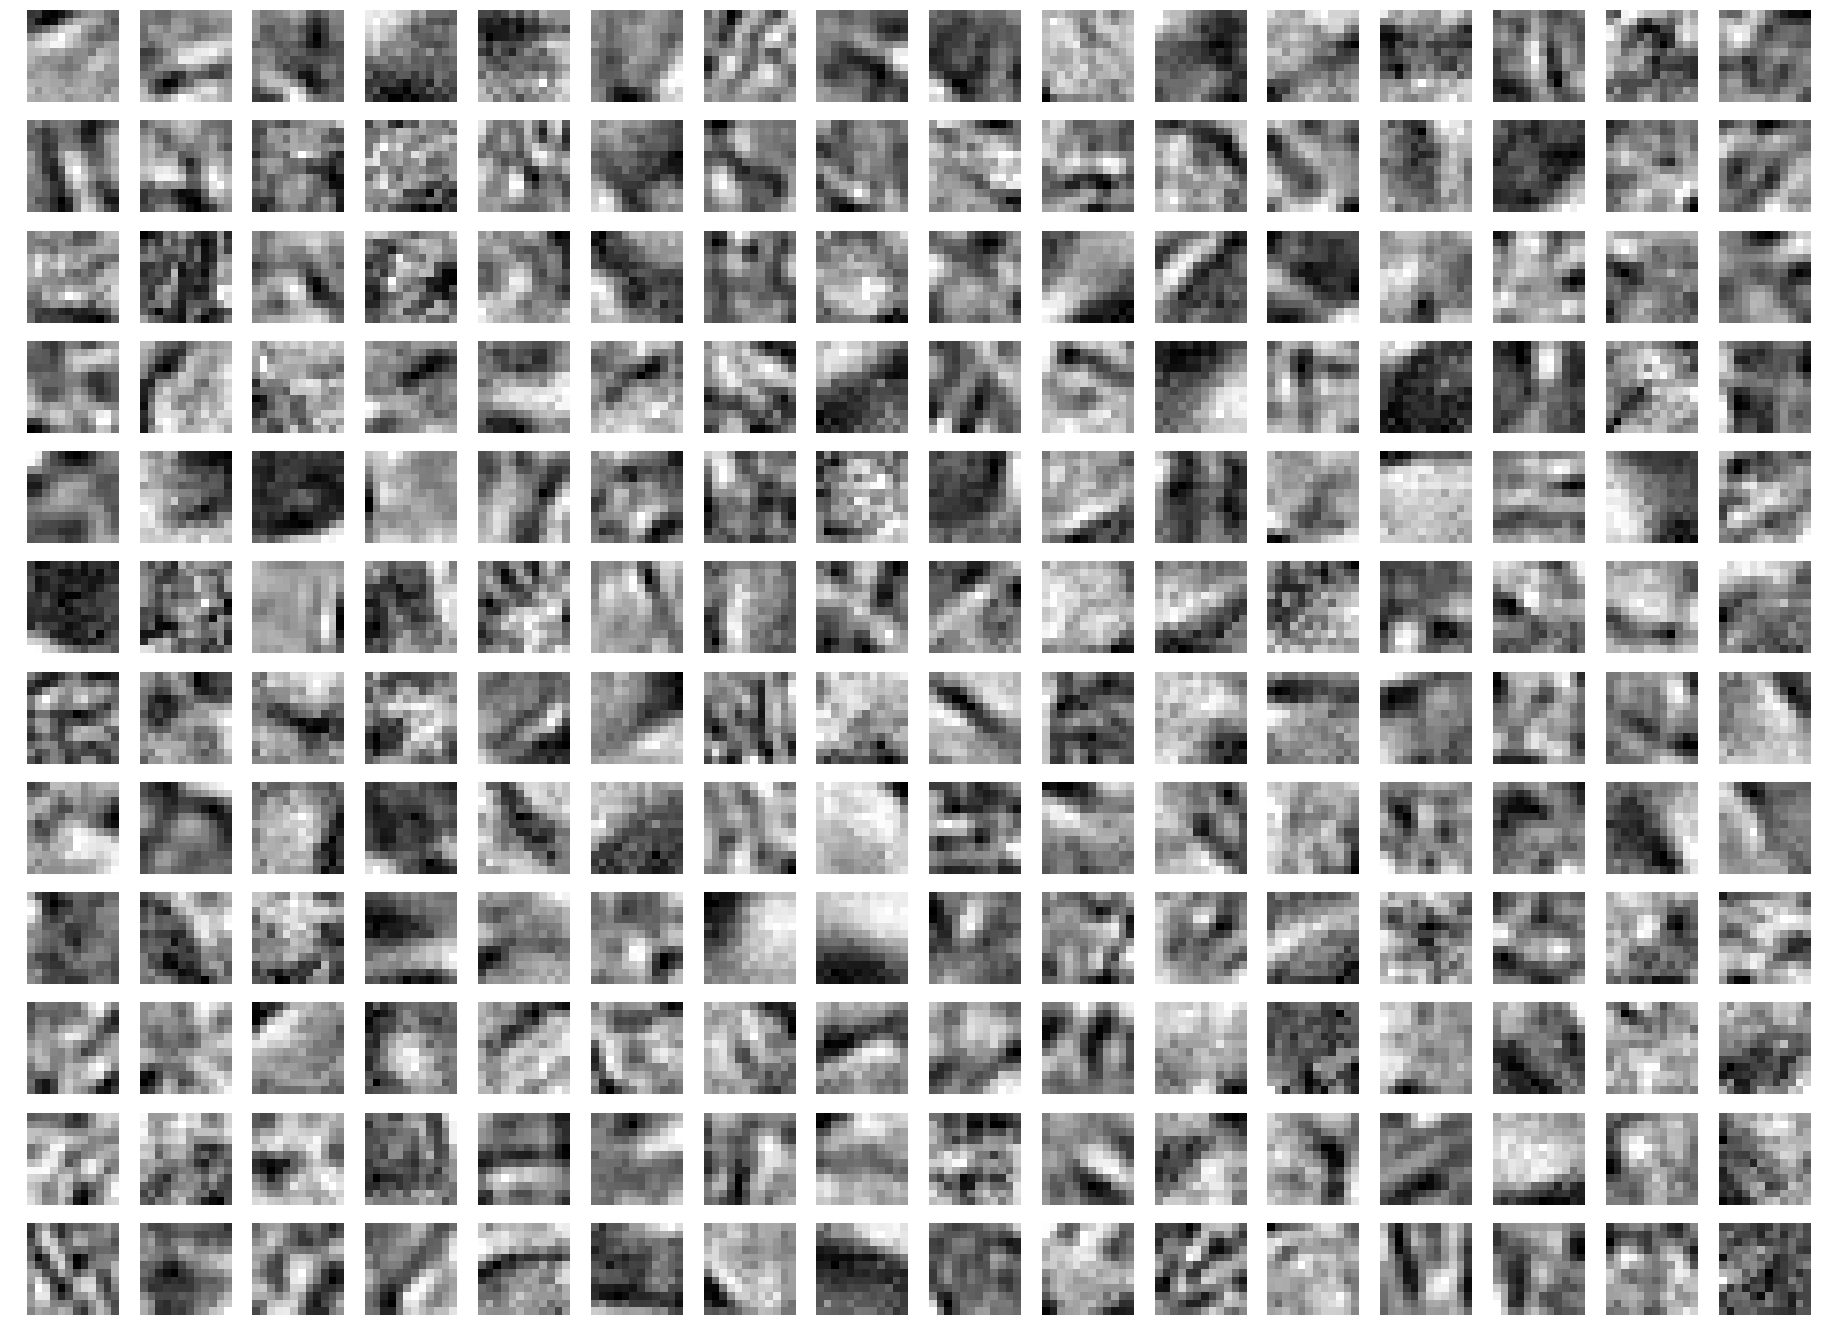

In [272]:
nrows = 12 
ncols = 16
plt.figure(figsize = (ncols*2, nrows*2)) 
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(Dict[:,i].reshape(12,12), cmap='gray')
    plt.axis('off')
plt.show()

Even if some atoms show unstable elements, I think that the converged dictionary looks similar with the results presented in paper.

## Monitor the convergence of the SGD algorithm 

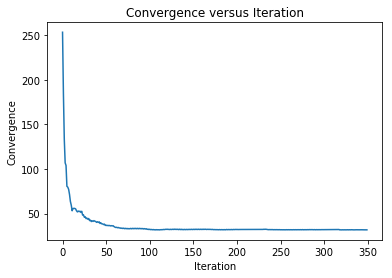

In [275]:
#Convergence Plot
plt.plot(range(len(Converge)), Converge)
plt.title("Convergence versus Iteration")
plt.ylabel('Convergence')
plt.xlabel('Iteration')
plt.show()

## How long does it take to converge? 

In [274]:
print(str(round(Time,4))+" seconds")

23.5732 seconds


## Experiment with a step size, constant or decreasing

In [262]:
etaList=[0.001,0.0025,0.005,0.0075,0.01]
TimeList=[]
for i in etaList:
    print(i)
    D,C,T=SparseCoding(eta=i,Display=False)
    TimeList.append(T)

0.001
0.0025
0.005
0.0075
0.01


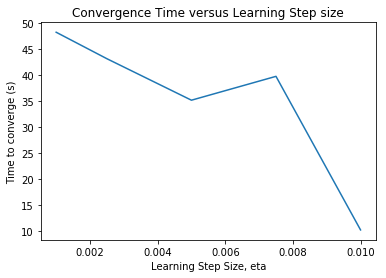

In [264]:
plt.plot(etaList, TimeList)
plt.title("Convergence Time versus Learning Step size")
plt.ylabel('Time to converge (s)')
plt.xlabel('Learning Step Size, eta')
plt.show()

I expect that as learning step size increases, the time to converge will be decrease. The result looks reasonable. Note that when we run the algorithm with the same eta, 0.005, the convergence time is changed. In addition, the time at eta 0.0075 is higer than at 0.005. It is possible because we select patches randomly and initial dictionary is also randomly selected.


One issue is that when I try to set eta higher than 0.01 such as 0.05 or 1, there were error with the following message : "ValueError: Input contains NaN, infinity or a value too large for dtype('float64').". I try to figure out and conclude that for a certain case, a value is too large for the type. Since I set patch randomly, it is hard to fix the issue. In google, I find that there are many users who have the same issue when they use sklearn. Thus, I only test between 0.001 and 0.01.

## Show reconstruction of patches images using the sparse representation 

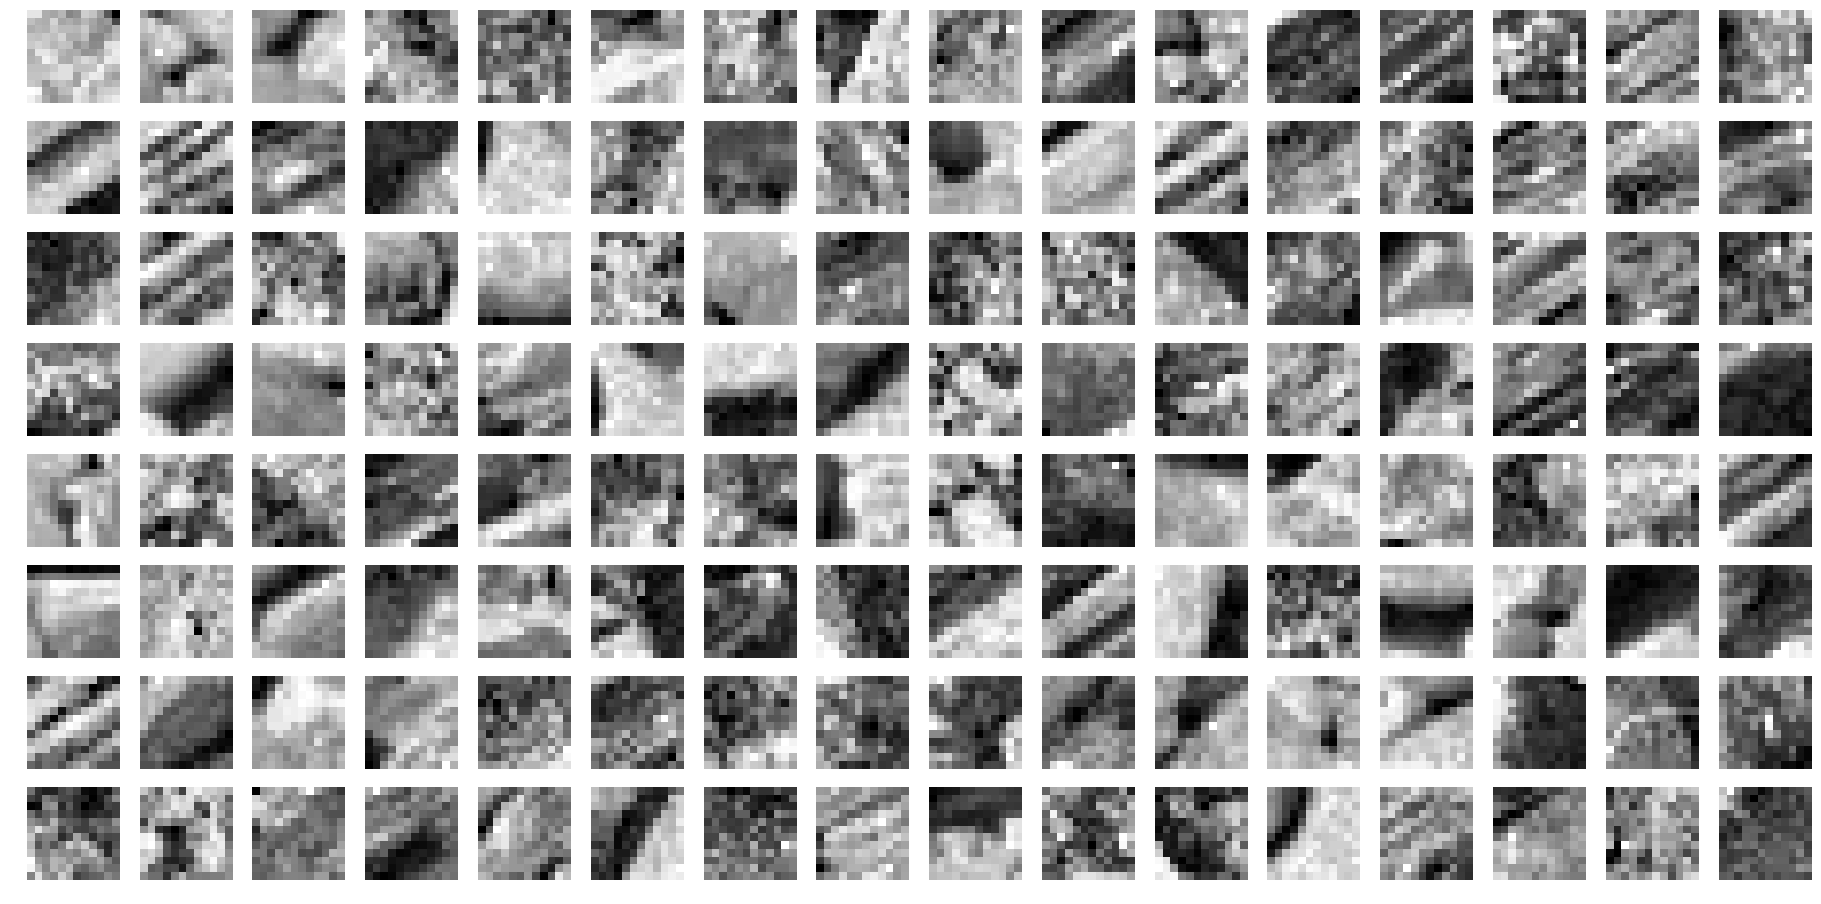

In [259]:
#Display ramdom patches
Patch=sample_random_square_patches(images[:,:,0], 128, 12)
Patch=Patch.reshape(dim, k)

nrows = 8
ncols = 16
plt.figure(figsize = (ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(Patch[:,i].reshape(12,12), cmap='gray')
    plt.axis('off')
plt.show()

The above patches are from the first picture in the dataset.

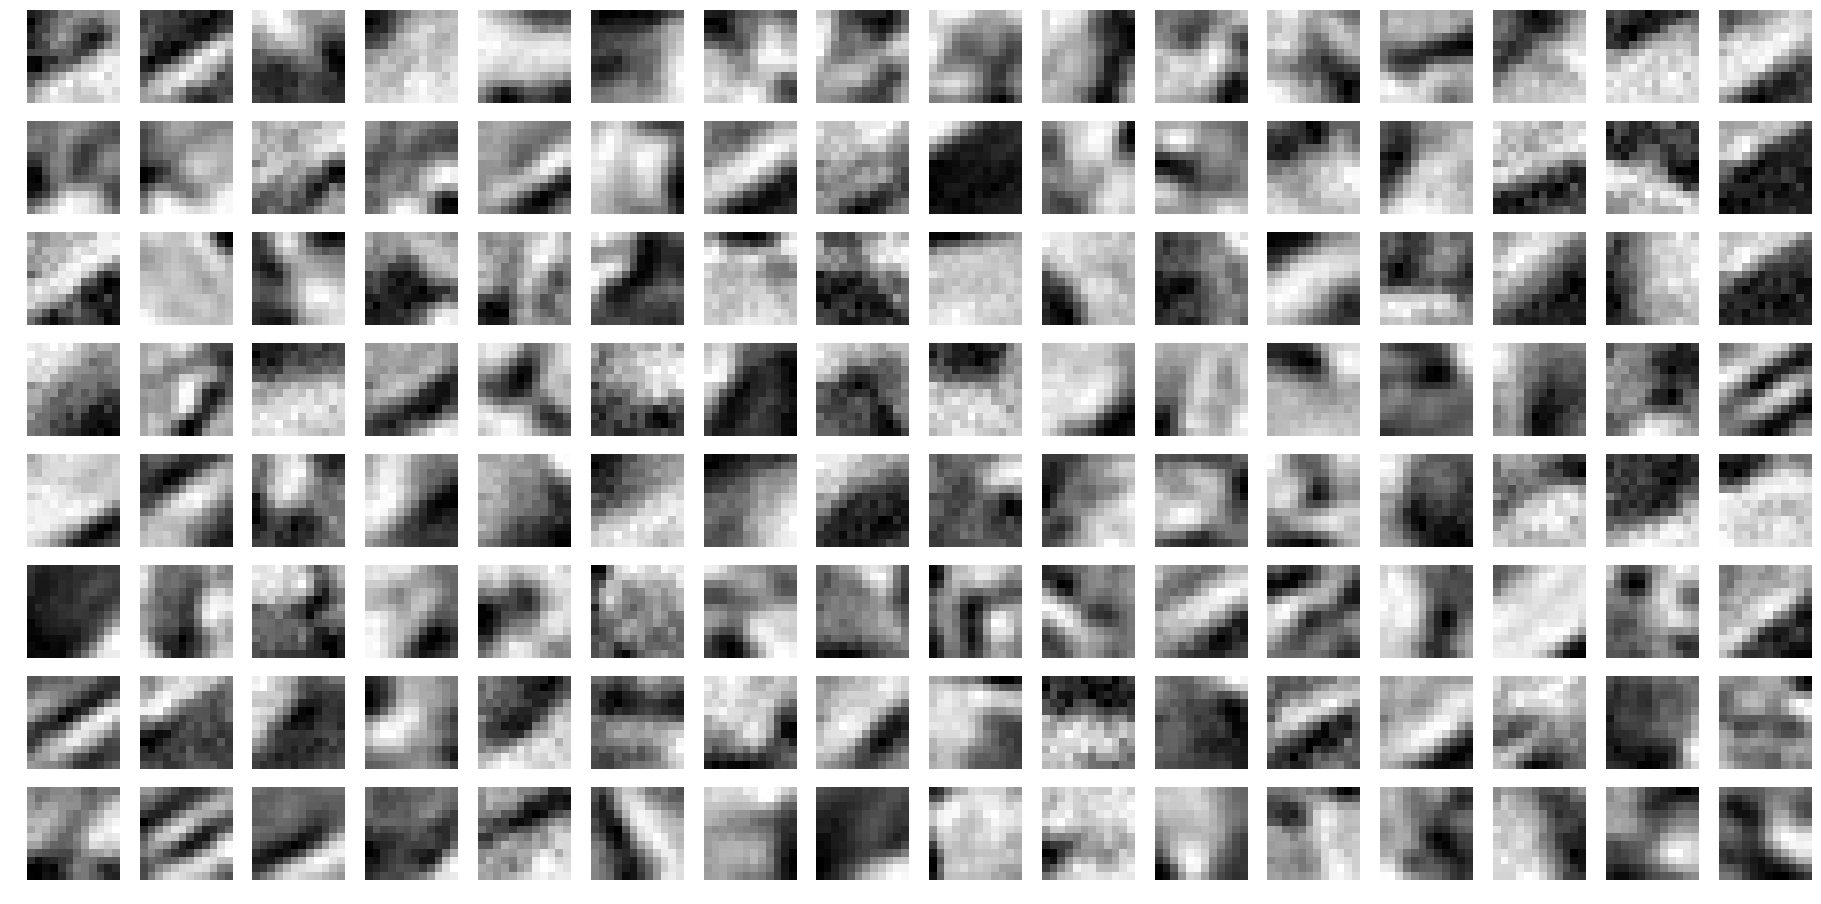

In [230]:
#Display the reconstruction of the patches
Patch_Lasso = Lasso(alpha=0.005) #Lasso model
Patch_Lasso.fit(Dict, Patch)
Patch_alpha = Patch_Lasso.coef_.T

RePatch=np.dot(Dict,Patch_alpha)

nrows = 8
ncols = 16
plt.figure(figsize = (ncols*2, nrows*2)) 
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(RePatch[:,i].reshape(12,12), cmap='gray')
    plt.axis('off')
plt.show()